### Hamming Distance using Open-Iris

#### 1. Importing Libraries

In [1]:
import numpy as np
from src.data.CasiaIrisDataset import CasiaIrisDataset
from src.data.datasetUtils import splitDataset
from src.evaluation.hamming_distance import elaborate_batch, calculate_distance_matrix
import iris
from src.lib.cnn_utils import identification_test_all_vs_all, identification_test_probe_vs_gallery, \
    verification_probe_vs_gallery, verification_all_vs_all
from src.utils.plotting import plot_far_frr_roc

C:\Users\flypi\PycharmProjects\iris-recognition-system\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2. Configuration

In [2]:
# Dataset Path
dataset_dir = "F:\\Dataset\\Casia"

#### 3. Load the dataset

In [3]:
# Load the dataset
dataset = CasiaIrisDataset(dataset_dir, transform=[], encoding=True)

# Splitting the Dataset: Train(0%), Validation(0%), Test(20%)
train_dataset, val_dataset, test_dataset = splitDataset(dataset, 0.2, 0.1)

Dataset size: 18725
Loading dataset...
Splitting dataset...
Training dataset size: 13496
Validation dataset size: 1505
Testing dataset size: 3724


##### 3.1 Test version of the dataset

Iris path: F:\Dataset\Casia\CASIA-Iris-Thousand-Encoded\001\L\S5001L00.json
Label: 1


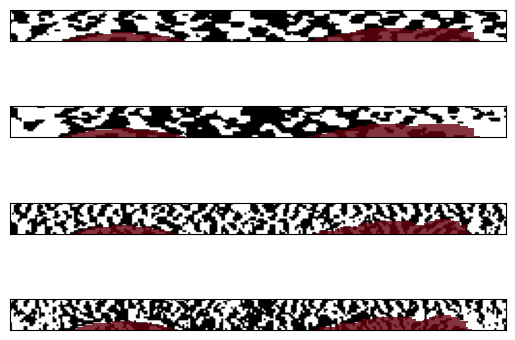

In [4]:
# Set the dataset to evaluation mode
dataset.eval()

# Load a batch of images
batch = next(iter(test_dataset))

# Iris visualization
iris_visualizer = iris.visualisation.IRISVisualizer()

print(f"Iris path: {batch[2]}")
print(f"Label: {batch[1]}")
canvas = iris_visualizer.plot_iris_template(batch[0])

### 4. Generate distance matrix

In [ ]:
# Merging templates and labels into a single list from the batches
templates, labels = elaborate_batch(test_dataset)
num_templates = len(templates)
if num_templates == 0:
    raise ValueError("No valid templates found. Check dataset structure.")

# Compute distance matrix in parallel
distance_matrix = calculate_distance_matrix(templates)
print("Distance matrix computed.", distance_matrix)

  0%|          | 0/13868176 [00:00<?, ?it/s]

##### 4.1 Save the results

In [ ]:
# Save results into a CSV file
np.savetxt("distance_matrix_3724.csv", distance_matrix, delimiter=",")
print("Distance matrix saved as 'distance_matrix.csv'.")

# Save labels into a text file
with open("labels.txt", "w") as f:
    for label in labels:
        f.write(f"{label}\n")

##### 4.2 Load the results

In [5]:
# Load matrix from CSV
matrix = np.loadtxt('.\\src\\data\\distance_matrix_3724.csv', delimiter=',')

# Check the shape of the loaded matrix
print(matrix.shape)

# Load labels from file
with open('.\\src\\data\\labels.txt', 'r') as f:
    labels = f.readlines()

# Remove newline characters
labels = [label.strip() for label in labels]

(3724, 3724)


#### 4.3 Elaborate the results

In [6]:
# Identify rows to keep where the diagonal element is zero
rows_to_keep = np.where(np.diag(matrix) == 0)[0]

# If no rows meet the condition, return an empty square matrix
if len(rows_to_keep) == 0:
    filtered_matrix = np.zeros((0, 0), dtype=matrix.dtype)
else:
    # Filter the matrix
    filtered_matrix = matrix[rows_to_keep, :]
    # Ensure it is square by keeping only the relevant columns
    filtered_matrix = filtered_matrix[:, rows_to_keep]

# Filter labels
labels = np.array([labels[i] for i in rows_to_keep])

### 5. All vs All Test

##### 5.1. Identification Test

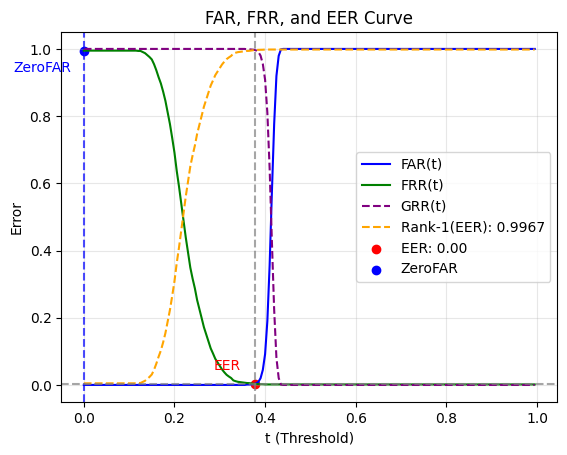

In [8]:
# Compute the thresholds, DIR, GRR, FAR, FRR
thresholds, DIR, GRR, FAR, FRR = identification_test_all_vs_all(filtered_matrix, labels)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=np.array(DIR))

##### 5.2. Verification Test

In [9]:
# Compute the GAR, FAR, FRR, GRR
GAR, FAR, FRR, GRR = verification_all_vs_all(filtered_matrix, labels)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=None)

KeyboardInterrupt: 

#### 6. Probe vs Gallery Test

##### 6.1. Split the Dataset

In [ ]:
# Step 1: Split indices into Gallery (60%) and Probe (40%)
N = len(filtered_matrix)
indices = np.arange(N)
np.random.shuffle(indices)  # Shuffle indices to randomize splitting

split_point = int(0.6 * N)  # Calculate the 60% split point
gallery_indices = indices[:split_point]  # First 60% indices
probe_indices = indices[split_point:]  # Remaining 40% indices

labels_gallery = labels[gallery_indices]
labels_probe = labels[probe_indices]

# Step 2: Extract sub-matrices
probe_vs_gallery = filtered_matrix[np.ix_(probe_indices, gallery_indices)]

##### 6.2. Identification Test

In [ ]:
# Compute the GAR, FAR, FRR, GRR
thresholds, DIR, GRR, FAR, FRR = identification_test_probe_vs_gallery(probe_vs_gallery, labels_probe, labels_gallery)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=np.array(DIR))

##### 6.3. Verification Test


In [ ]:
# Compute the GAR, FAR, FRR, GRR
thresholds, DIR, GRR, FAR, FRR = verification_probe_vs_gallery(probe_vs_gallery, labels_probe, labels_gallery)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=None)